# Develop `tracer_thalweg_and_surface` Figure Module

Development of functions for `nowcast.figures.research.tracer_thalweg_and_surface` web site figure module.

This is an example of developing the functions for a web site figure module in a notebook.
It follows the function organization patterns described in
[Creating a Figure Module](https://salishsea-nowcast.readthedocs.io/en/latest/figures/create_fig_module.html) docs.

If you choose to develop your figure in a notebook,
the next step is to create a module like
`nowcast.figures.research.tracer_thalweg_and_surface`
and a notebook like
[TestTracerThalwegAndSurfaceModule]()
that tests it in the nowcast system context.

In [14]:
import datetime
import os
from types import SimpleNamespace

import cmocean
import matplotlib.pyplot as plt
from matplotlib import gridspec
import netCDF4 as nc
import numpy as np
import scipy.io as sio

import salishsea_tools
from salishsea_tools import visualisations as vis
from salishsea_tools import (teos_tools, tidetools, viz_tools, geo_tools)

import nowcast
import nowcast.figures.shared
import nowcast.figures.website_theme

In [2]:
%matplotlib inline

We know for sure that we need to develop:

* a `_prep_plot_data()` function
* a `_prep_fig_axes()` function
* a `make_figure()` function that the `make_plots` worker will call

Since the figure will have 2 axes
(a vertical thalweg slice, and a horizontal surface slice)
we also know that we need to develop 2 axes plotting functions:

* `_plot_thalweg()`
* `_plot_surface()`

## `_prep_plot_data()` Function

In [62]:
def _prep_plot_data(tracer_grid, bathy, lons, lats, mesh_mask, coastline, depth_integrated):
    lon_range = (-125.5, -122.4)
    lat_range = (48.5, 50.25)
    sj, ej = 200, 770
    si, ei = 20, 370   
    
    lons_subset = lons[sj:ej, si:ei]
    lats_subset = lats[sj:ej, si:ei]
    if depth_integrated:
        grid_heights = mesh_mask.variables['e3t_0'][:][0].reshape(tracer_grid.shape[1], 1, 1)
        height_weighted = tracer_grid[0, :, sj:ej, si:ei]*grid_heights
        surface_var = height_weighted.sum(axis=0)
    else:
        surface_var = tracer_grid[0, 0, sj:ej, si:ei]
    surface_var = np.ma.masked_where(mesh_mask["tmask"][0, 0, sj:ej, si:ei] == 0, surface_var)
    
    thal_clevels, surf_clevels, show_thalweg_cbar = surf_thalweg_clevels(tracer_grid, surface_var)
    
    if 'standard_name' in tracer_grid.ncattrs():
        tracer_name = tracer_grid.standard_name
    elif 'long_name' in tracer_grid.ncattrs():
        tracer_name = tracer_grid.long_name
    else:
        tracer_name = "Var"
    
    return SimpleNamespace(
        tracer_grid=tracer_grid[0,:,:,:],
        var_ma=surface_var,
        bathy=bathy,
        lons=lons,
        lats=lats,
        lons_subset=lons_subset,
        lats_subset=lats_subset,
        mesh_mask=mesh_mask,
        coastline=coastline,
        lon_range=lon_range,
        lat_range=lat_range,
        thal_clevels=thal_clevels,
        surf_clevels=surf_clevels,
        show_thalweg_cbar=show_thalweg_cbar,
        tracer_name=tracer_name,
        units=tracer_grid.units,
        depth_integrated=depth_integrated,
    )

In [4]:
def surf_thalweg_clevels(tracer_grid, surface_var):
    percent_98_surf = np.percentile(surface_var, 98)
    percent_2_surf = np.percentile(surface_var, 2)
    
    percent_98_grid = np.percentile(np.ma.masked_values(tracer_grid, 0), 98)
    percent_2_grid = np.percentile(np.ma.masked_values(tracer_grid, 0), 2)
    
    overlap = max(0, min(percent_98_surf, percent_98_grid) - max(percent_2_surf, percent_2_grid))
    magnitude = (percent_98_surf - percent_2_surf) + (percent_98_grid - percent_2_grid)
    if(2*overlap/magnitude > 0.5):
        max_clevel = max(percent_98_surf, percent_98_grid)
        min_clevel = min(percent_2_surf, percent_2_grid)
        thal_clevels = np.arange(min_clevel, max_clevel, (max_clevel - min_clevel)/20.0)
        surf_clevels = thal_clevels
        show_thalweg_cbar = False
    else:
        thal_clevels = np.arange(percent_2_grid, percent_98_grid, (percent_98_grid - percent_2_grid)/20.0)
        surf_clevels = np.arange(percent_2_surf, percent_98_surf, (percent_98_surf - percent_2_surf)/20.0)
        show_thalweg_cbar = True
    return thal_clevels, surf_clevels, show_thalweg_cbar

In [21]:
mesh_mask = nc.Dataset('/results/nowcast-sys/NEMO-forcing/grid/mesh_mask_SalishSea2.nc')

coastline = sio.loadmat('/ocean/rich/more/mmapbase/bcgeo/PNW.mat')

grid_B = nc.Dataset('/results/nowcast-sys/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, lons, lats = tidetools.get_bathy_data(grid_B)

grid_T = nc.Dataset('/results/SalishSea/nowcast-green/01apr16/SalishSea_1d_20160401_20160401_grid_T.nc')
ptrc_T = nc.Dataset('/results/SalishSea/nowcast-green/01apr16/SalishSea_1d_20160401_20160401_ptrc_T.nc')

tracer_grid = ptrc_T.variables['PHY2']

In [6]:
plot_data = _prep_plot_data(tracer_grid, bathy, lons, lats, mesh_mask, coastline, depth_integrated=True)

## `_prep_fig_axes() Function`

In [109]:
def _prep_fig_axes(figsize, theme):
    fig = plt.figure(
        figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor'])
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[1.3, 1])

    ax_thalweg = fig.add_subplot(gs[0])
    ax_thalweg.set_axis_bgcolor(theme.COLOURS['axes']['background'])

    ax_surface = fig.add_subplot(gs[1])
    ax_surface.set_axis_bgcolor(theme.COLOURS['axes']['background'])

    return fig, (ax_thalweg, ax_surface)

In [103]:
def _plot_tracer_thalweg(ax, plot_data, cmap, theme):
    cbar = vis.contour_thalweg(
        ax, plot_data.tracer_grid, plot_data.bathy, plot_data.lons, plot_data.lats, plot_data.mesh_mask, 
        'gdept', clevels=plot_data.thal_clevels, cmap=cmap,
        thalweg_file='/results/nowcast-sys/tools/bathymetry/thalweg_working.txt',
        cbar_args={'fraction':0.030,'pad':0.04, 'aspect': 45}
    )
    ax.set_xlim(0, 590)
    ax.set_ylim(450, 0)
    if not plot_data.show_thalweg_cbar:
        cbar.remove()  
    else:
        contour_intervals = plot_data.thal_clevels
        label = plot_data.tracer_name + " [" + plot_data.units + "]"
        _map_cbar_labels(cbar, contour_intervals[::2], theme, label)
    ax.set_xlabel("Distance along thalweg [km]",color=theme.COLOURS['text']['axis'],fontproperties=theme.FONTS['axis'])
    ax.set_ylabel("Depth [m]",color=theme.COLOURS['text']['axis'],fontproperties=theme.FONTS['axis'])
    theme.set_axis_colors(ax)
    

In [9]:
def _map_cbar_labels(cbar, contour_intervals, theme, label):
    cbar.set_ticks(contour_intervals)
    cbar.ax.axes.tick_params(labelcolor=theme.COLOURS['cbar']['tick labels'])
    cbar.set_label(
        label,
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis'])

In [107]:
def _plot_tracer_surface(ax, plot_data, cmap, theme):
#     nowcast.figures.shared.plot_map(ax,plot_data.coastline, lon_range=plot_data.lon_range, lat_range=plot_data.lat_range)
    x, y = np.meshgrid(np.arange(20, 370, dtype=int), np.arange(200, 770, dtype=int))
    mesh = ax.contourf(
        x, y,
#         plot_data.lons_subset, plot_data.lats_subset, 
        plot_data.var_ma, levels=plot_data.surf_clevels, cmap=cmap, 
        extend='both')
    
    viz_tools.set_aspect(ax)
    ax.set_axis_bgcolor('burlywood')
    ax.set_xlabel('Grid x', color=theme.COLOURS['text']['axis'],fontproperties=theme.FONTS['axis'])
    ax.set_ylabel('Grid y', color=theme.COLOURS['text']['axis'],fontproperties=theme.FONTS['axis'])
    theme.set_axis_colors(ax)
    
    cbar = plt.colorbar(mesh, ax=ax, fraction=0.034, pad=0.04, aspect=45)
    contour_intervals = plot_data.surf_clevels
    if plot_data.depth_integrated:
        label = plot_data.tracer_name + " [" + plot_data.units + "*m]"
    else:
        label = plot_data.tracer_name + " [" + plot_data.units + "]"
    _map_cbar_labels(cbar, contour_intervals[::2], theme, label)

In [92]:
def make_figure(tracer_grid, bathy, lons, lats, mesh_mask, coastline, cmap,
                               depth_integrated=False,
                               figsize=(20, 12), theme=nowcast.figures.website_theme,
):  
    plot_data = _prep_plot_data(tracer_grid, bathy, lons, lats, mesh_mask, coastline, depth_integrated)
    fig, (ax_thalweg, ax_surface) = _prep_fig_axes(figsize, theme)
    _plot_tracer_thalweg(ax_thalweg, plot_data, cmap, theme)
    _plot_tracer_surface(ax_surface, plot_data, cmap, theme)
    return fig

2.75 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


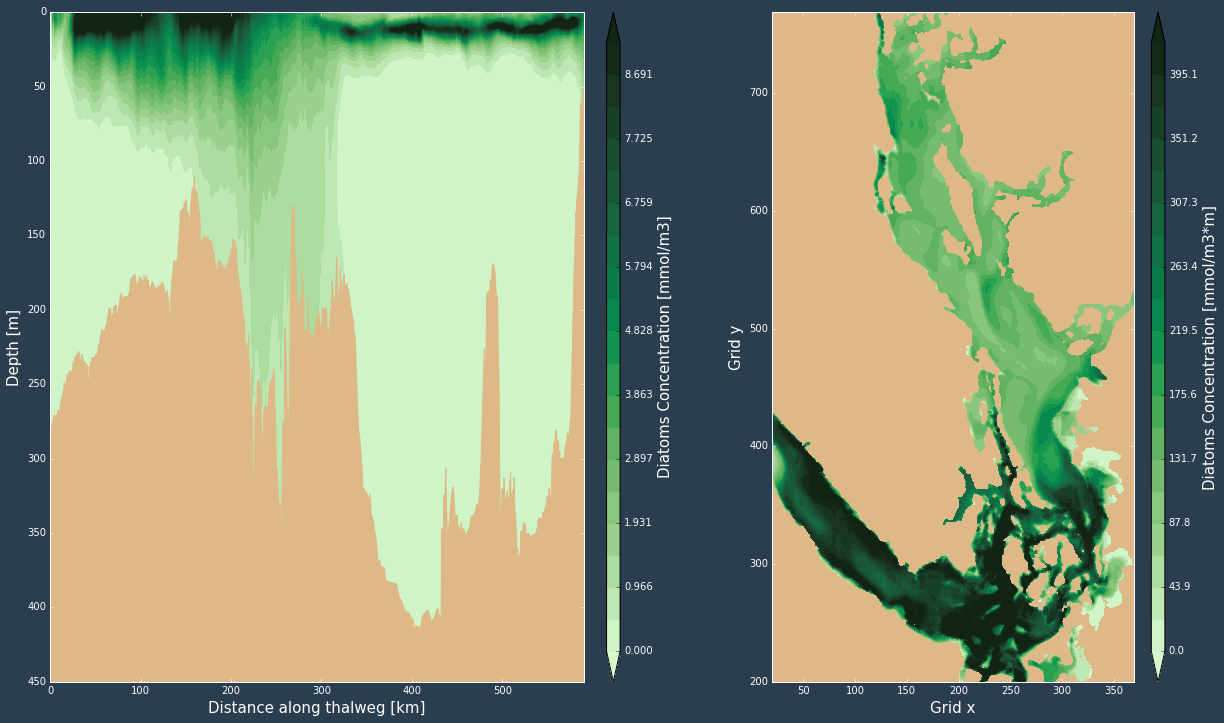

In [110]:
%%timeit -n1 -r1

fig = make_figure(
    tracer_grid, bathy, lons, lats, mesh_mask, coastline, cmap=cmocean.cm.algae, depth_integrated=True)

In [ ]:
for tracer in ptrc_T.variables.keys():
    var = ptrc_T.variables[tracer]
    if(len(var.shape) == 4):
        thalweg_and_surface_plot = tracer_thalweg_and_surface(var, bathy, lons, lats, mesh_mask, coastline, False)
        plt.show(thalweg_and_surface_plot)

In [ ]:
def f(a,b,c,e,d):
    print(a + b + c + d + e)

In [ ]:
x = {'c':3,'d':4,'e':5}
if x:(1,2,**x)
else:f(1,2,3,4,6)